In [3]:
import numpy as np, matplotlib.pyplot as plt, random, time
from functools import lru_cache
from pyquil import Program, get_qc
from pyquil.gates import *
import os
from pyquil.quilatom import quil_sin, quil_cos, Parameter
from pyquil.quilbase import DefGate
from pyquil.latex import display, to_latex
# import Peres_helpers as hf
import pickle
from collections import Counter

# Helpers
def dura(func):
    '''
    A wrapper function to calculate the time of any process we want.
    '''
    def wrapper(*args, **kwargs):
        start = time.time()
        print(f'{func.__name__} has started.')
        val = func(*args, **kwargs)
        ty_res = time.gmtime(time.time() - start)
        res = time.strftime("%H:%M:%S",ty_res)
        print(f'{func.__name__} completed in {res}')
        return val
    return wrapper

def params_real():
	'''
	Generates parameters to prepare random REAL quantum states.
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(3)]))
	phi = np.array([(np.pi)*random.randint(0,1) for _ in range(3)])
	params = zip(theta, phi)
	return list(params)
def params_complex():
	'''
	Generates parameters to prepare COMPLEX quantum states.
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(3)]))
	phi = np.array([2*np.pi*random.uniform(0,1) for _ in range(3)])
	params = zip(theta, phi)
	return list(params)

n_shots= 10_000
e = 0

def p_norm(u, p):
    p = np.cos(p/2)
    N = np.sqrt(
        1 + 2 * p * np.sqrt(1-p**2) * np.cos((u[1][0] - u[0][0])/2) * np.cos((u[1][1] - u[0][1])/2)
    )
    
    return N

def get_params(u, p):
    N = p_norm(u,p)
    p = np.cos(p/2)
#     print(N)
    z0 = (p/N) * np.exp(-1j * u[0][1] / 2) * np.cos(u[0][0]/2) + (np.sqrt(1-p**2)/N) * np.exp(-1j * u[1][1] / 2) * np.cos(u[1][0]/2)
    z1 = (p/N) * np.exp(1j * u[0][1] / 2) * np.sin(u[0][0]/2) + (np.sqrt(1-p**2)/N) * np.exp(1j * u[1][1] / 2) * np.sin(u[1][0]/2)
    
#     print(z0,z1)
    
    modz0 = np.abs(z0)
    modz1 = np.abs(z1)
    
    argz0 = np.angle(z0)
    argz1 = np.angle(z1)
    
    theta = 2 * np.arccos(modz0)
    phi = argz1 - argz0
    
    return (theta, phi)

# Sigma calculation. This function executes the circuit.
def sigma(params, params_ancilla):
    '''
    Compile and run the circuit given the parameters. The list of outputs is returned.
    '''
    # 	theta, phi = params[0], params[1] # Store thetas and phis in seperate tuples.
    theta, phi = get_params(params, params_ancilla)
#     print(theta, phi)

    bitstrings = qc.run(exe, memory_map={'theta': [theta], 'phi': [phi]}) # Stores the output of the circuit run.
    return bitstrings

# Gammas for different pairs of states.
def g(u, p):
	'''
	Calls the sigma function with different values of parameters correponding to the configurations, |ψ12>, |ψ1> and |ψ2>. Returns a
	dictionary with configurations as keys and output as values (which are lists).
	'''
	s12 = sigma(u, p) # Circuit for superposition of states.

	p = 0
	s1 = sigma(u, p) # Circuit for state 1.

	p = np.pi
	s2 = sigma(u, p) # Circuit for state 2.

	return {'s12': s12, 's1': s1, 's2': s2}

# Computing all the three gammas.
@dura # To calculate the time taken for all the circuits to run.
def f(u,p):
	'''
	Calls the g function to run the circuit for different configurations and returns a dictionary with 'a', 'b', 'c' as keys and the corresponding 
	outputs of the three configurations. This marks the end of what the Quantum computer must be used for. After this it is all about post-
	processing the data.
	'''
	alpha = g([u[0], u[1]], p[0]) # Running for alpha
	beta = g([u[1], u[2]], p[1]) # Running for beta
	gamma = g([u[2], u[0]], p[2]) # Running for gamma

	res = {'a': alpha, 'b': beta, 'c': gamma}

	return res


def circuit(s):
    circ = Program()
    
    c = circ.declare('ro', 'BIT')
    theta = circ.declare('theta', 'REAL')
    phi = circ.declare('phi', 'REAL')
    
    circ += RY(theta, s)
    circ += RZ(phi, s)
    
    circ += MEASURE(s, c)
    
    circ.wrap_in_numshots_loop(n_shots)
    
    return circ

def s_probs(res):
    gammas = {}

    for gamma in res.keys():
        output_s12 = [''.join(list(map(str,x))) for x in res[gamma]['s12']]
        output_s1 = [''.join(list(map(str,x))) for x in res[gamma]['s1']]
        output_s2 = [''.join(list(map(str,x))) for x in res[gamma]['s2']]
        counts_s12 = Counter(output_s12)
        counts_s1 = Counter(output_s1)
        counts_s2 = Counter(output_s2)
        gammas[gamma] = {'s12': counts_s12, 's1': counts_s1, 's2': counts_s2}
#         print(gammas)

    return gammas

def get_gammas(gammas):
    gam_values = {}
    for gamma in gammas.keys():
        val = (gammas[gamma]['s12']['1'] - (probs[gamma]/all_N[gamma])**2 * gammas[gamma]['s1']['1'] - (1-probs[gamma]**2)/all_N[gamma]**2 * gammas[gamma]['s2']['1']) / (2 * (probs[gamma]/all_N[gamma]) * (np.sqrt(1-probs[gamma]**2)/all_N[gamma]) * np.sqrt(gammas[gamma]['s1']['1'] * gammas[gamma]['s2']['1']))
        gam_values[gamma] = {'val': val}

    val = gam_values['a']['val']**2 + gam_values['b']['val']**2 + gam_values['c']['val']**2 - 2*gam_values['a']['val']*gam_values['b']['val']*gam_values['c']['val']
    gam_values['F'] = {'val': val}

    return gam_values

circ = circuit(4)


qc = get_qc('Aspen-9')
exe = qc.compile(circ)

all_results = []
for i in range(17):
    print(f'Run: {i}')
    u = params_complex() # Parameters for three random states is chosen. For real states, call "params_real()".
    p = np.array([random.uniform(0,np.pi) for _ in range(3)]) # The coefficients of superposition is chosen.
    probs = {'a': np.abs(np.cos(p[0]/2)), 'b': np.abs(np.cos(p[1]/2)), 'c': np.abs(np.cos(p[2]/2))} # A dict of coefficients for calculating F below.
    all_N = {'a': p_norm([u[0],u[1]], p[0]), 'b': p_norm([u[1],u[2]], p[1]), 'c': p_norm([u[2],u[0]], p[2])}

    res = f(u,p) # The measurement results are returned from the above functions.
#     sp = s_probs(res)
#     result = get_gammas(sp)
#     all_results.append([u,p,res])

    with open(f'peres_sq_2021_05_27_bit_4_shots_1e4_run_{i}.pkl', 'wb') as file:
        pickle.dump([u,p,res], file)

Run: 12
f has started.
f completed in 00:00:47
Run: 13
f has started.
f completed in 00:00:47
Run: 14
f has started.
f completed in 00:00:47
Run: 15
f has started.
f completed in 00:00:47
Run: 16
f has started.
f completed in 00:00:47
Run: 17
f has started.


UserMessageError: ERROR: It looks like you've tried to run a program against a QPU but do
not currently have a reservation on one. To reserve time on Rigetti
QPUs, use the command line interface, qcs, which comes pre-installed
in your QMI. From within your QMI, type:

    qcs reserve --lattice <lattice-name>

For more information, please see the docs at
https://www.rigetti.com/qcs/docs/reservations or reach out to Rigetti
support at support@rigetti.com.

In [39]:
for i in range(13):
    with open(f'peres_sq_2021_05_15_bit_4_shots_8192_run_{i}.pkl', 'rb') as file:
        data = pickle.load(file)

    print(data[2]['F'], end='\n\n')

{'val': 0.7314209539659788}

{'val': 0.8323602800459138}

{'val': 0.9683038515291535}

{'val': 1.0976589085750854}

{'val': 0.8959891006643238}

{'val': 0.995539532916532}

{'val': 1.0153201274881491}

{'val': 0.9076191364132713}

{'val': 0.517316565703435}

{'val': 1.3709784442219448}

{'val': 1.127837633584831}

{'val': 0.748099207940544}

{'val': 0.9730107549822148}



In [40]:
data[2]['F'].values()

dict_values([0.9730107549822148])

In [12]:
import pickle, numpy as np, matplotlib.pyplot as plt
f_values = []
a_values = []
b_values = []
c_values = []
for i in range(13):
    with open(f'peres_sq_2021_05_15_bit_4_shots_8192_run_{i}.pkl', 'rb') as file:
        data = pickle.load(file)

#     print(data[2]['F'], end='\n\n')
    f_values.append(data[2]['F']['val'])
    a_values.append(data[2]['a']['val'])
    b_values.append(data[2]['b']['val'])
    c_values.append(data[2]['c']['val'])
f_values

[0.7314209539659788,
 0.8323602800459138,
 0.9683038515291535,
 1.0976589085750854,
 0.8959891006643238,
 0.995539532916532,
 1.0153201274881491,
 0.9076191364132713,
 0.517316565703435,
 1.3709784442219448,
 1.127837633584831,
 0.748099207940544,
 0.9730107549822148]

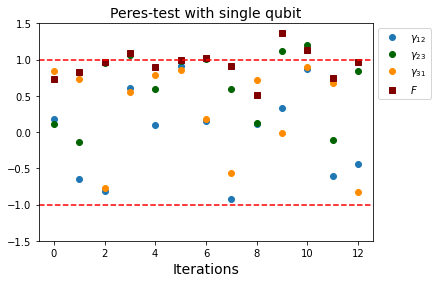

In [15]:
x_values = np.arange(len(f_values))

plt.plot(x_values, a_values, 'o', label='$\\gamma_{12}$')
plt.plot(x_values, b_values, 'o', color='darkgreen', label='$\\gamma_{23}$')
plt.plot(x_values, c_values, 'o', color='darkorange', label='$\\gamma_{31}$')
plt.plot(x_values, f_values, 's', color='maroon', label='$F$')

plt.axhline(y=1, ls='dashed', color='red')
plt.axhline(y=-1, ls='dashed', color='red')
plt.ylim([-1.5,1.5])
plt.xlabel('Iterations', size=14)
# plt.ylabel('$F$', size=14)
plt.title('Peres-test with single qubit', size=14)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('peres_sq_2021_05_15_bit_4_shots_8192.pdf', bbox_inches='tight')
plt.show()